## Lab 2.4: Platki sniadaniowe - klasyfikacja

### Paczki i dane

In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.gridspec import GridSpec
from sklearn.metrics import classification_report, confusion_matrix

In [58]:
# Ustawienia dla wykresów
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'DejaVu Sans'

# Wczytanie danych
df = pd.read_csv('Płatki-sniadaniowe-cereals.txt', sep='\t')

# Definicja zmiennych do analizy
nutrients = ['kalorie', 'cukry', 'weglowodany', 'proteiny', 'tluszcz', 'blonnik']
nutrient_names = ['Kalorie', 'Cukry', 'Węglowodany', 'Proteiny', 'Tłuszcz', 'Błonnik']

## Analiza danych - wykresy


### Wykresy skrzypcowe

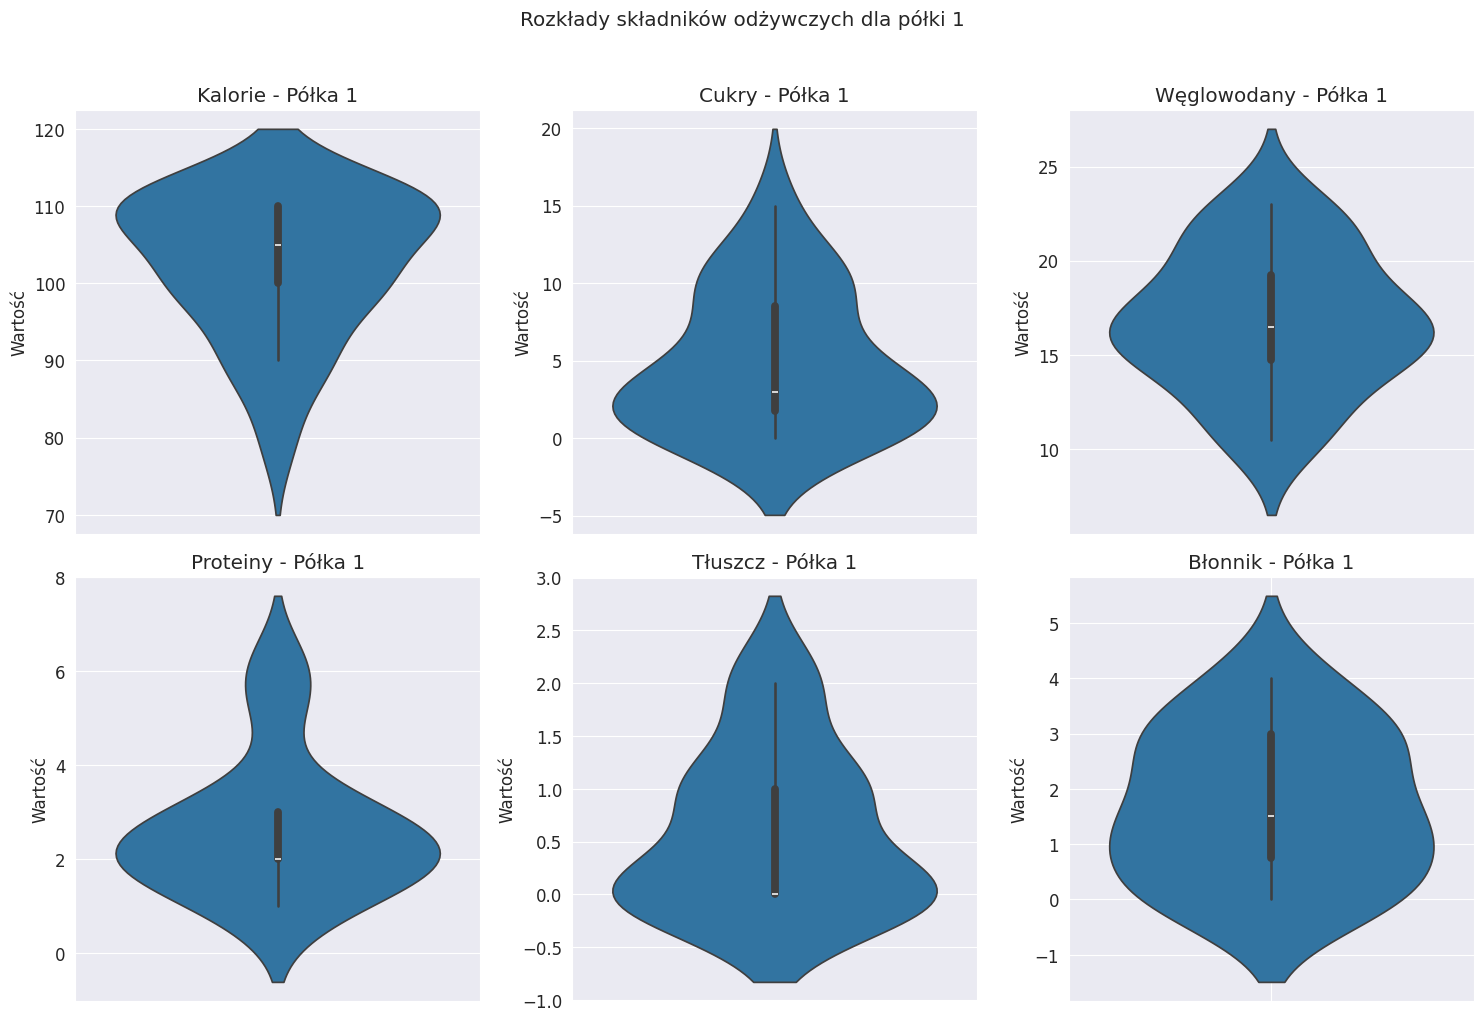

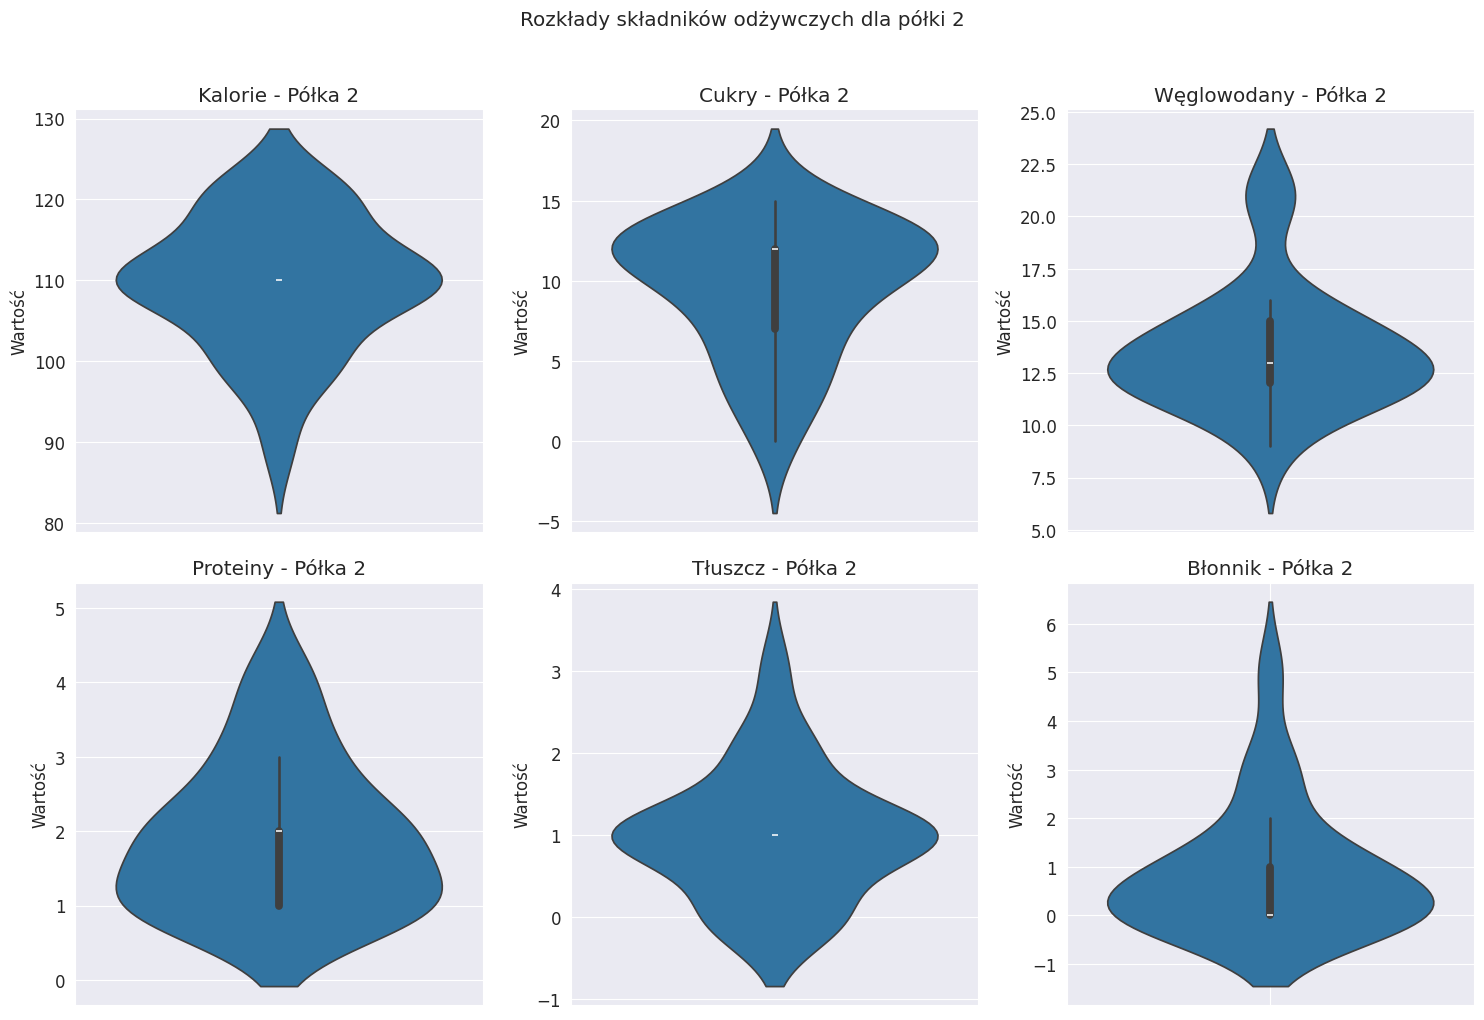

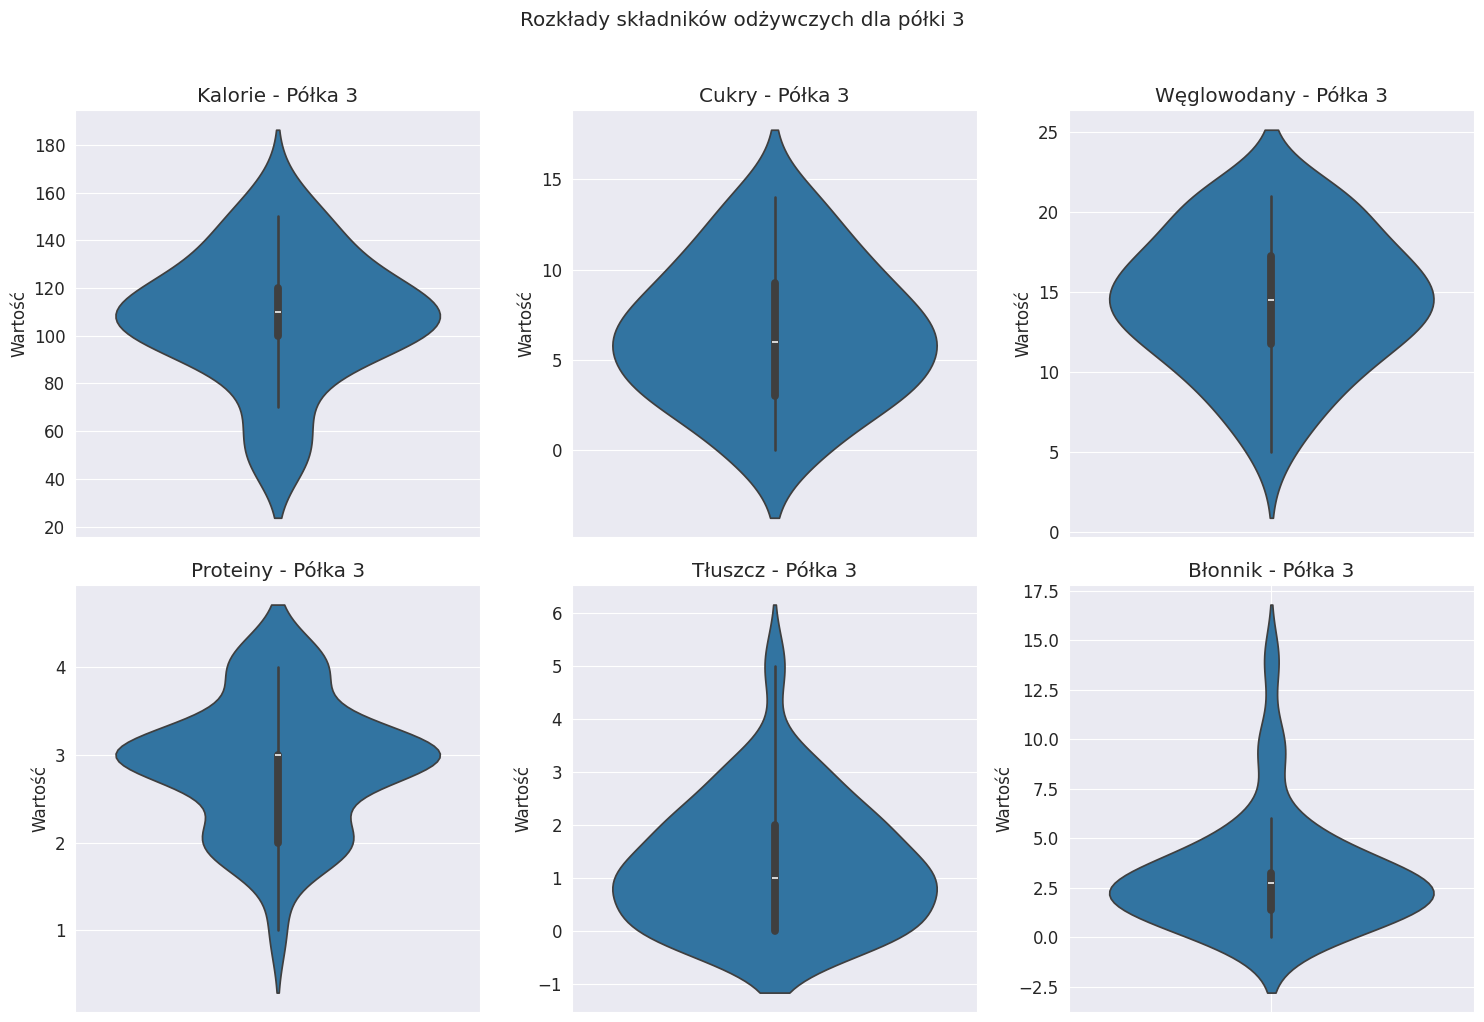

In [59]:
def create_detailed_violin_plots():
    # Tworzymy osobny wykres dla każdej półki
    for shelf in sorted(df['Liczba_polek'].unique()):
        shelf_data = df[df['Liczba_polek'] == shelf]

        plt.figure(figsize=(15, 10))
        for i, (nutrient, name) in enumerate(zip(nutrients, nutrient_names)):
            plt.subplot(2, 3, i + 1)
            sns.violinplot(y=nutrient, data=shelf_data, inner='box')
            plt.title(f'{name} - Półka {shelf}')
            plt.ylabel('Wartość')

        plt.suptitle(f'Rozkłady składników odżywczych dla półki {shelf}', y=1.02)
        plt.tight_layout()
        plt.grid(True)
        plt.show()


create_detailed_violin_plots()

### Wykresy radarowe dla profilu odżywczego kazdej półki



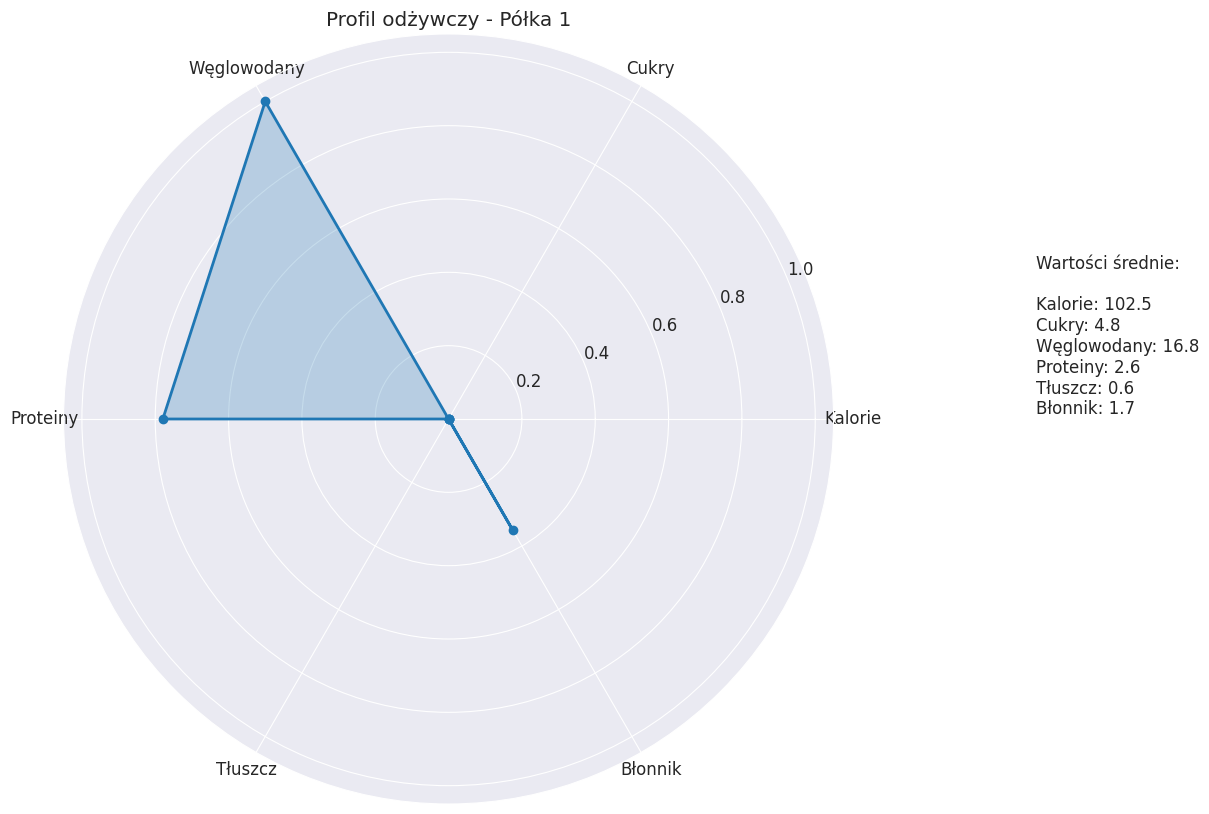

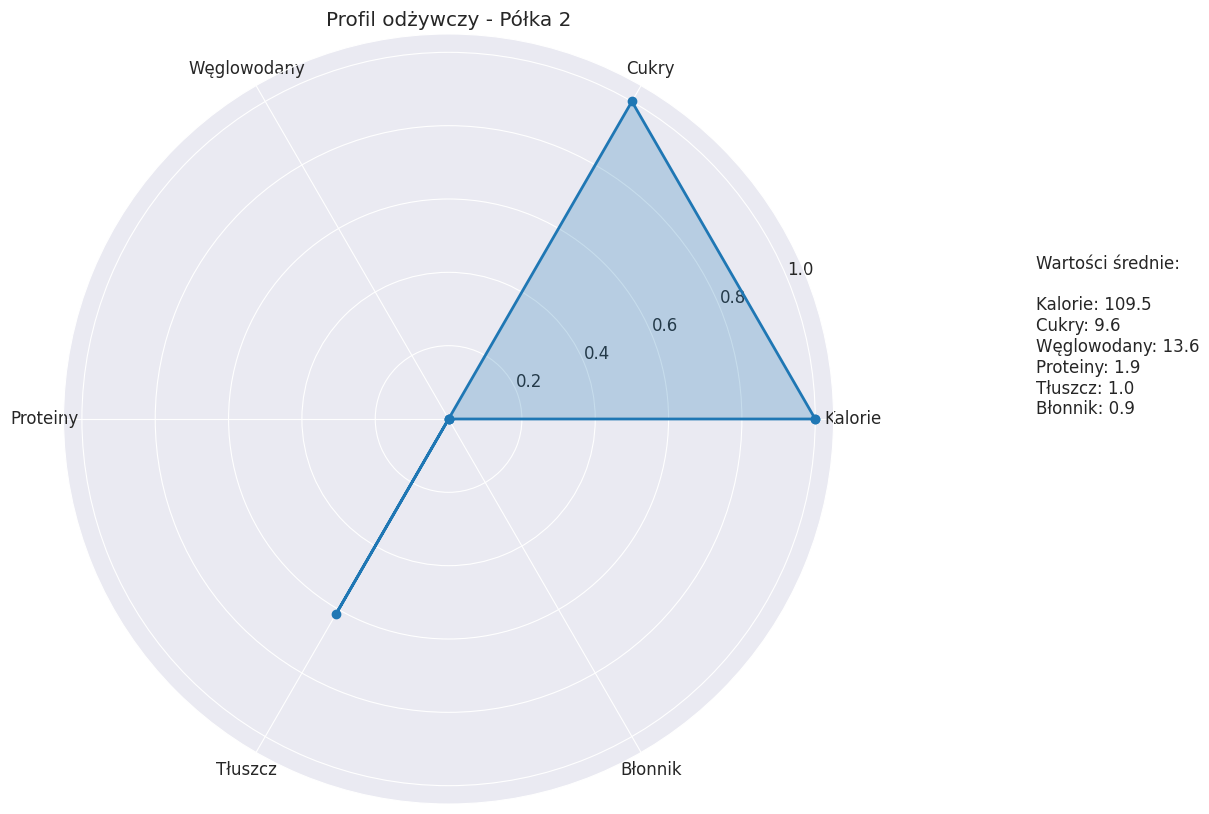

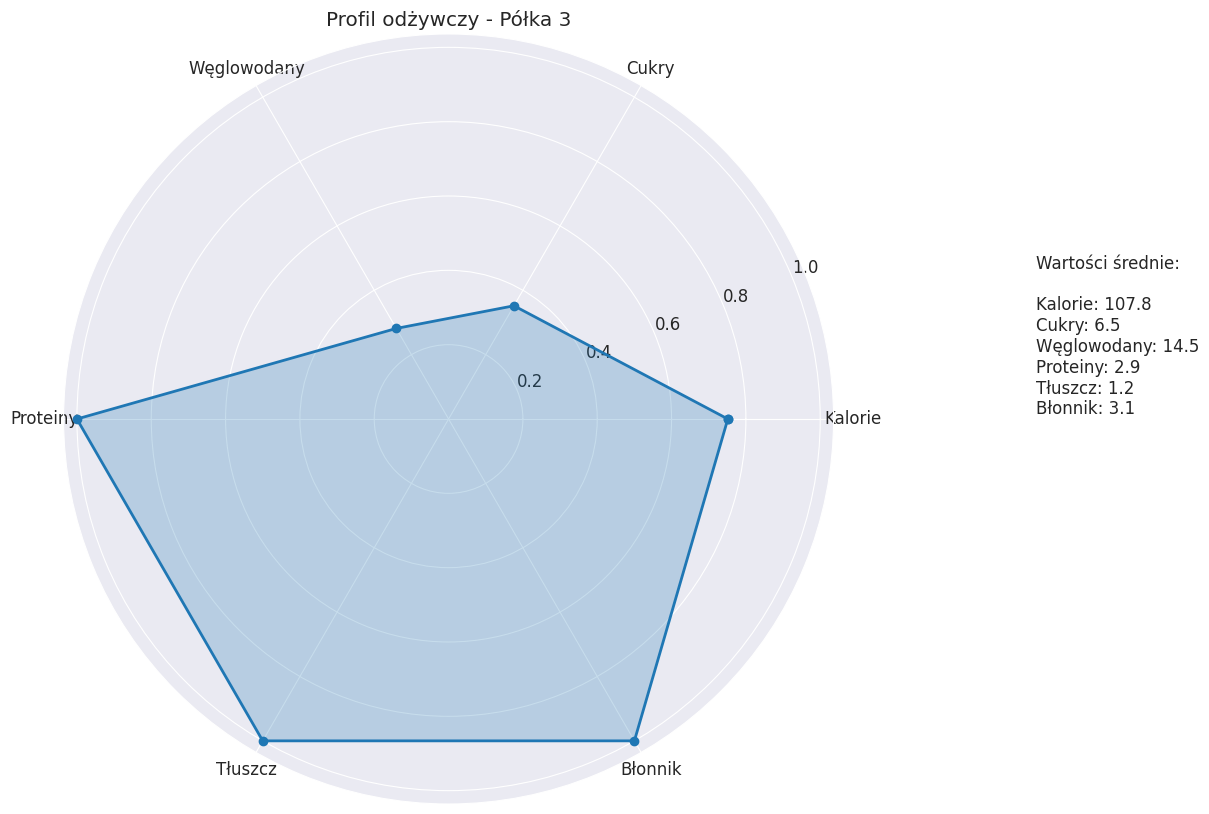

In [60]:
def create_radar_plots() -> None:
    # Tworzymy osobne wykresy dla każdej półki
    shelf_means = df.groupby('Liczba_polek')[nutrients].mean()

    # Normalizacja danych do 0,1 bo skala wartości jest różna
    shelf_means_norm = (shelf_means - shelf_means.min()) / (shelf_means.max() - shelf_means.min())

    # Linespace tworzy równo odległe wartości w zadanym przedziale
    angles = np.linspace(0, 2 * np.pi, len(nutrients), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Zamknięcie pętli

    for shelf in sorted(df['Liczba_polek'].unique()):
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

        values = shelf_means_norm.loc[shelf].values
        values = np.concatenate((values, [values[0]]))  # Konkatenacja ktora zamyka pętlę

        # Rysowanie wykresu
        ax.plot(angles, values, 'o-', linewidth=2, label=f'Półka {shelf}')
        ax.fill(angles, values, alpha=0.25)

        # Ustawienie nazw osi
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(nutrient_names)

        plt.title(f'Profil odżywczy - Półka {shelf}')

        # Dodanie oryginalnych wartości
        orig_values = shelf_means.loc[shelf].round(1)
        legend_text = '\n'.join([f'{name}: {value}'
                                 for name, value in zip(nutrient_names, orig_values)])
        plt.figtext(1.1, 0.5, f'Wartości średnie:\n\n{legend_text}',
                    bbox=dict(facecolor='white', alpha=0.8))

        plt.show()


create_radar_plots()

### Analiza skladu wedlug producenta - top 5


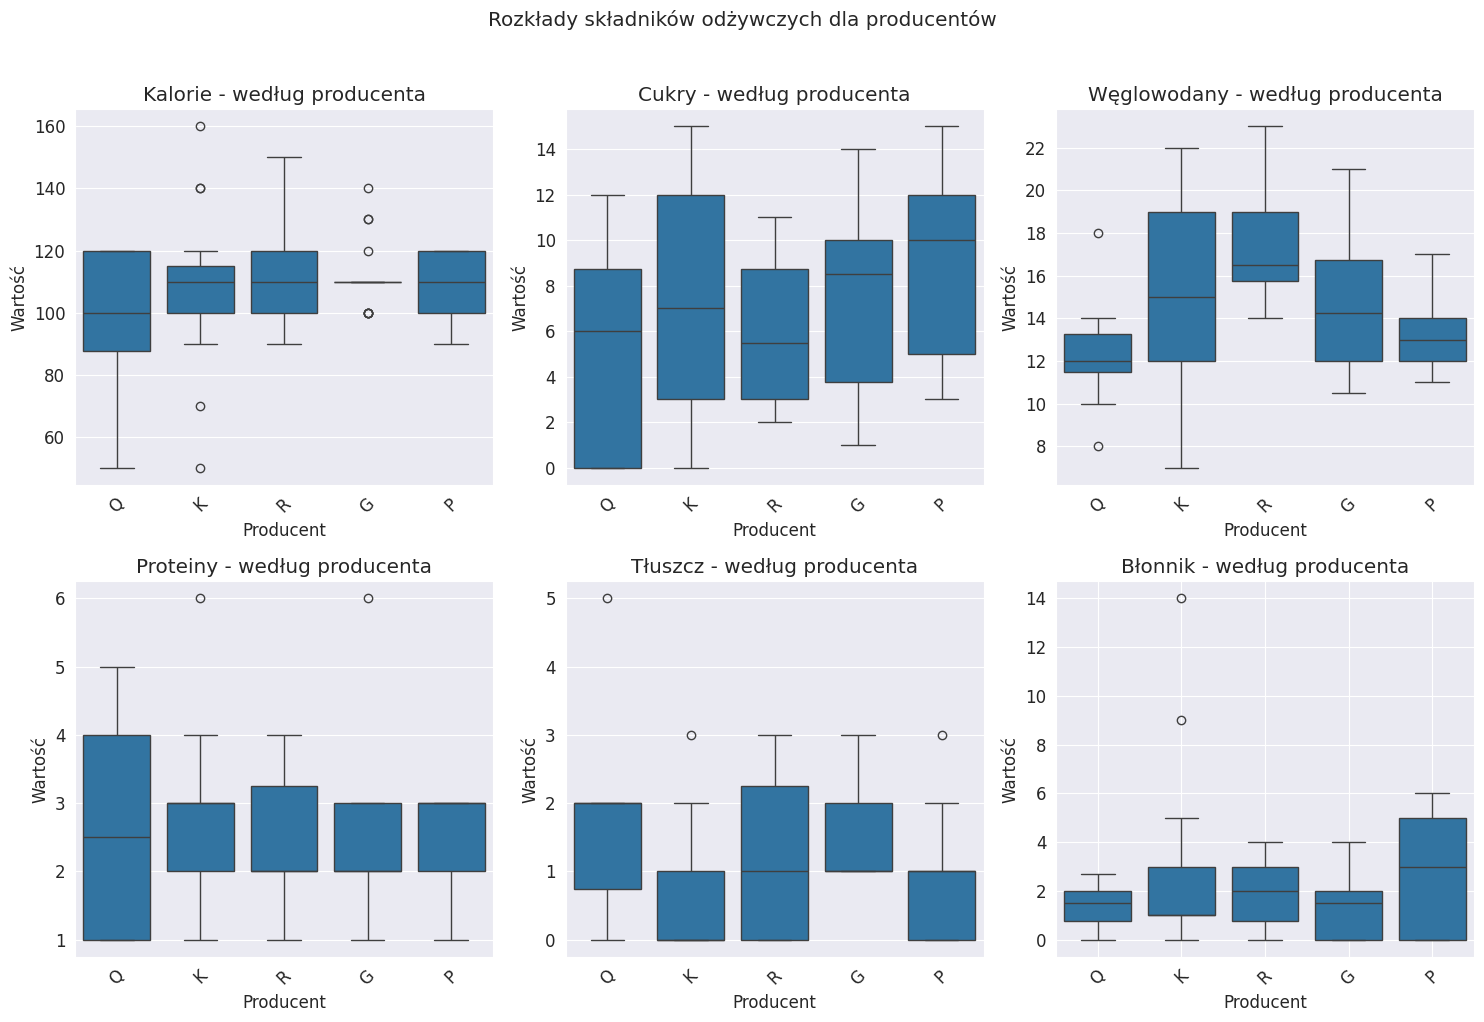

In [61]:
def analyze_by_manufacturer() -> None:
    # Grupowanie po producencie
    manufacturers = df['producent'].value_counts().head(5).index  # 5 najczęstszych producentów
    df_filtered = df[df['producent'].isin(manufacturers)]

    plt.figure(figsize=(15, 10))
    for i, (nutrient, name) in enumerate(zip(nutrients, nutrient_names)):
        plt.subplot(2, 3, i + 1)
        box_plot = sns.boxplot(x='producent', y=nutrient, data=df_filtered)
        plt.title(f'{name} - według producenta')
        plt.ylabel('Wartość')
        plt.xlabel('Producent')
        plt.xticks(rotation=45)

    plt.suptitle('Rozkłady składników odżywczych dla producentów', y=1.02)
    plt.tight_layout()
    plt.grid(True)
    plt.show()


analyze_by_manufacturer()

### Heatmapa srednich wartosci

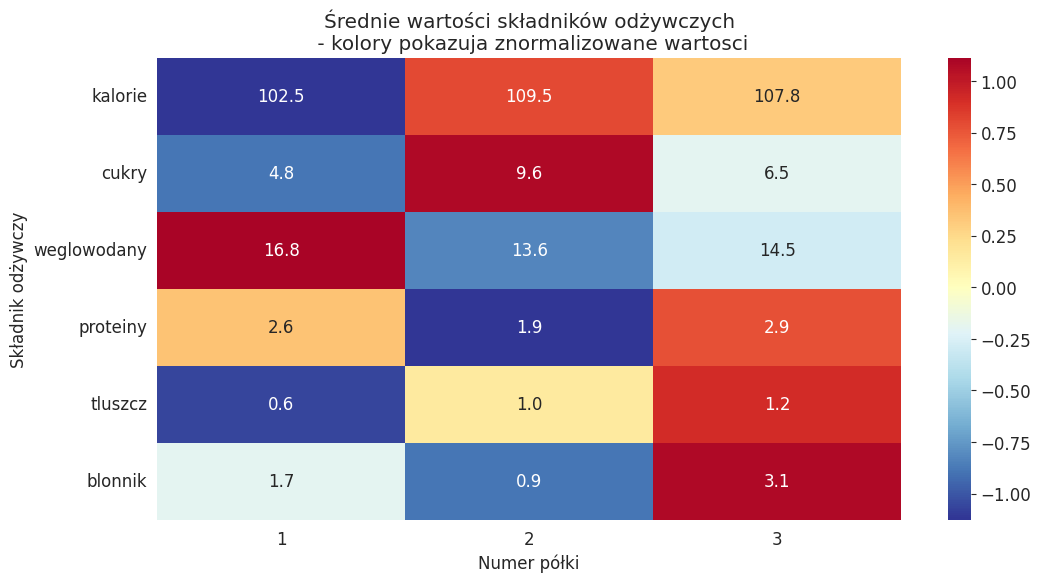

In [62]:
def create_nutrient_heatmap() -> None:
    shelf_means = df.groupby('Liczba_polek')[nutrients].mean()
    shelf_means_normalized = (shelf_means - shelf_means.mean()) / shelf_means.std()

    plt.figure(figsize=(12, 6))
    sns.heatmap(shelf_means_normalized.T,
                annot=shelf_means.T.round(1),
                fmt='.1f',
                cmap='RdYlBu_r',
                center=0)
    plt.title('Średnie wartości składników odżywczych\n - kolory pokazuja znormalizowane wartosci')
    plt.xlabel('Numer półki')
    plt.ylabel('Składnik odżywczy')
    plt.grid(True)
    plt.show()

create_nutrient_heatmap()

### Wykresy przedzialow srednich wartosci dla polek z 95% przedzialem ufności

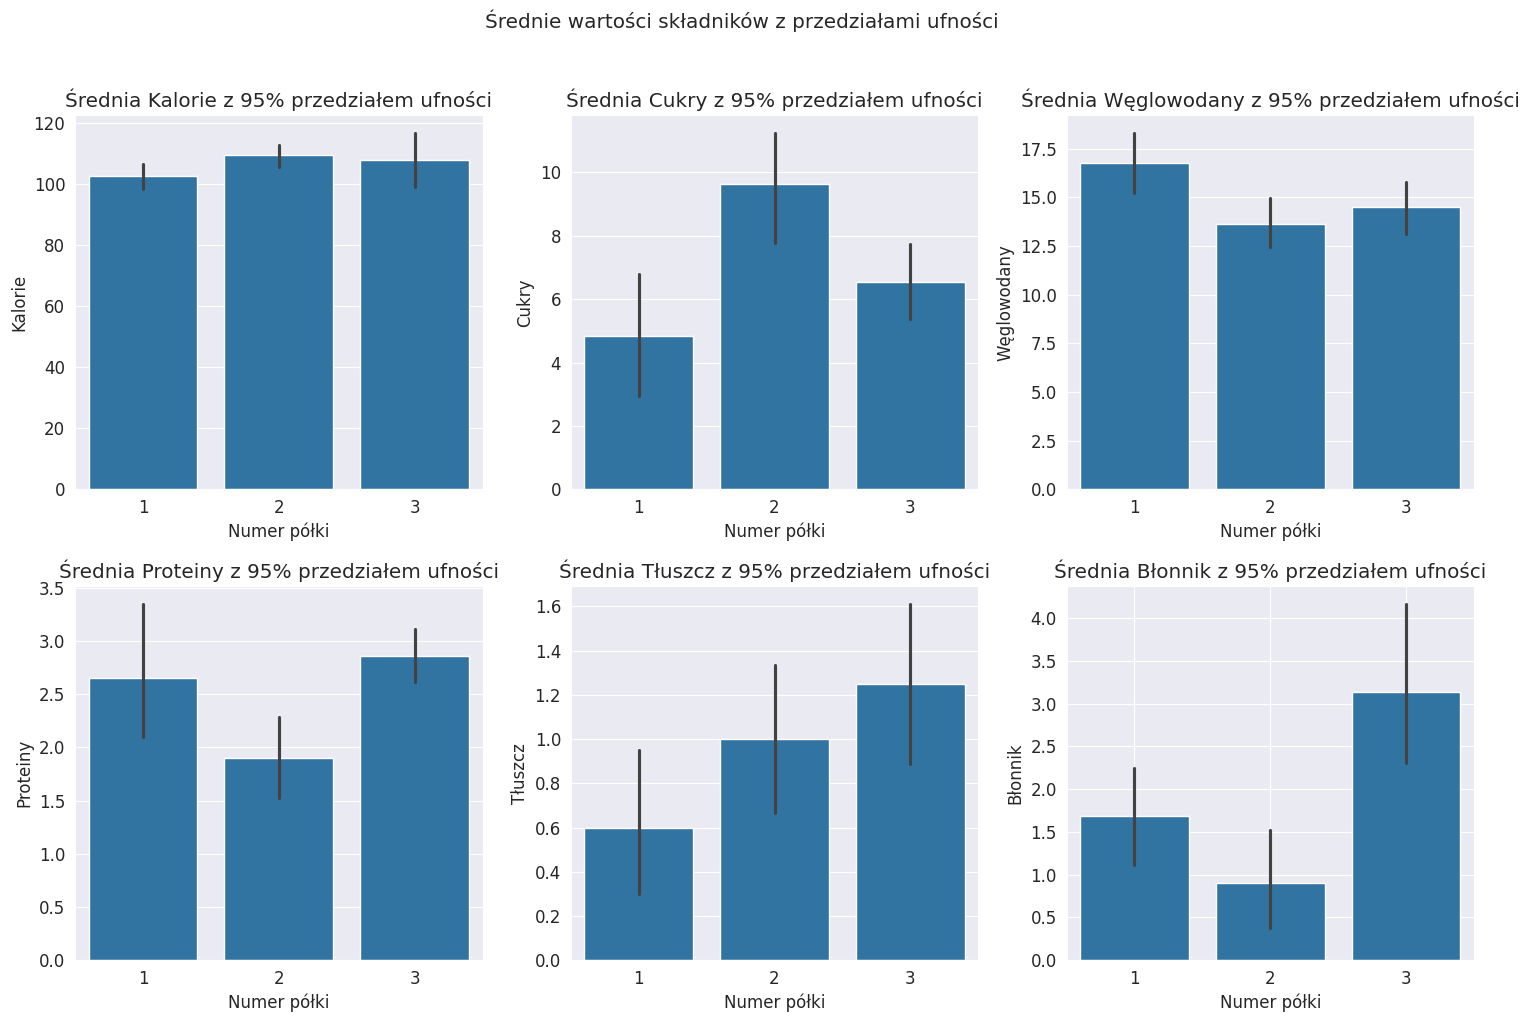

In [63]:
def plot_confidence_intervals() -> None:
    plt.figure(figsize=(15, 10))
    for i, (nutrient, name) in enumerate(zip(nutrients, nutrient_names)):
        plt.subplot(2, 3, i + 1)
        sns.barplot(x='Liczba_polek', y=nutrient, data=df, ci=95)
        plt.title(f'Średnia {name} z 95% przedziałem ufności')
        plt.xlabel('Numer półki')
        plt.ylabel(name)
    plt.suptitle('Średnie wartości składników z przedziałami ufności', y=1.02)
    plt.tight_layout()
    plt.grid(True)
    plt.show()
    
plot_confidence_intervals()

### Analiza korelacji miedzy potencjalnymi zmiennymi niezaleznymi

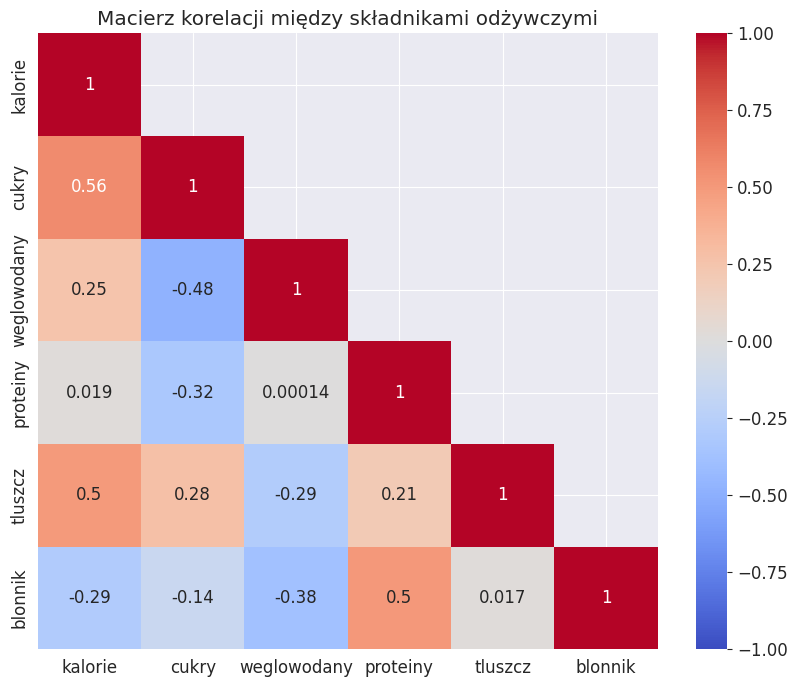

In [64]:
def plot_correlation_analysis() -> None:
    corr_matrix = df[nutrients].corr() # Macierz korelacji
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix), k=1) # Maskowanie górnej trójkątnej macierzy
    sns.heatmap(corr_matrix, 
                mask=mask, 
                annot=True, 
                cmap='coolwarm',
                vmin=-1, # Skala korelacji od -1 do 1 
                vmax=1,
                center=0)
    plt.title('Macierz korelacji między składnikami odżywczymi')
    plt.show()

plot_correlation_analysis()

### Analiza statystyczna - testy statystyczne np. dla P-value

In [65]:
def detailed_statistical_analysis() -> None:
    print("\nSzczegółowa analiza statystyczna składników:")

    for nutrient, name in zip(nutrients, nutrient_names):
        print(f"\n{name}:")

        # Statystyki opisowe
        stats_by_shelf = (df.groupby('Liczba_polek')[nutrient]
                          .agg(['count', 'mean', 'std', 'min', 'max']))
        print("\nStatystyki według półek:")
        print(stats_by_shelf.round(2))

        # Test Kruskal-Wallis
        groups = [group for _, group in df.groupby('Liczba_polek')[nutrient]]
        h_stat, p_val = stats.kruskal(*groups)
        print(f"\nTest Kruskal-Wallis:")
        print(f"H-statistic = {h_stat:.2f}")
        print(f"p-value = {p_val:.4f}")
        
detailed_statistical_analysis()


Szczegółowa analiza statystyczna składników:

Kalorie:

Statystyki według półek:
              count    mean    std  min  max
Liczba_polek                                
1                20  102.50   9.10   80  110
2                21  109.52   8.05   90  120
3                36  107.78  26.95   50  160

Test Kruskal-Wallis:
H-statistic = 4.02
p-value = 0.1343

Cukry:

Statystyki według półek:
              count  mean   std  min  max
Liczba_polek                             
1                20  4.85  4.51    0   15
2                21  9.62  4.13    0   15
3                36  6.53  3.84    0   14

Test Kruskal-Wallis:
H-statistic = 13.01
p-value = 0.0015

Węglowodany:

Statystyki według półek:
              count   mean   std   min   max
Liczba_polek                                
1                20  16.75  3.64  10.5  23.0
2                21  13.62  2.94   9.0  21.0
3                36  14.50  4.21   5.0  21.0

Test Kruskal-Wallis:
H-statistic = 8.10
p-value = 0.0175

Proteiny

In [66]:
# Podsumowanie analiz
print("\nPodstawowe wnioski z analizy:")
for nutrient in nutrients:
    shelf_means = df.groupby('Liczba_polek')[nutrient].mean() # Średnie wartości składników
    max_shelf = shelf_means.idxmax()
    min_shelf = shelf_means.idxmin()
    diff_percent = ((shelf_means[max_shelf] - shelf_means[min_shelf]) / shelf_means[min_shelf] * 100).round(2)
    
    print(f"\n{nutrient.capitalize()}:")
    print(f"- Różnica między półkami: {diff_percent:.1f}%")
    print(f"- Najwyższa średnia (półka {max_shelf}): {shelf_means[max_shelf]:.2f}")
    print(f"- Najniższa średnia (półka {min_shelf}): {shelf_means[min_shelf]:.2f}")


Podstawowe wnioski z analizy:

Kalorie:
- Różnica między półkami: 6.8%
- Najwyższa średnia (półka 2): 109.52
- Najniższa średnia (półka 1): 102.50

Cukry:
- Różnica między półkami: 98.3%
- Najwyższa średnia (półka 2): 9.62
- Najniższa średnia (półka 1): 4.85

Weglowodany:
- Różnica między półkami: 23.0%
- Najwyższa średnia (półka 1): 16.75
- Najniższa średnia (półka 2): 13.62

Proteiny:
- Różnica między półkami: 50.2%
- Najwyższa średnia (półka 3): 2.86
- Najniższa średnia (półka 2): 1.90

Tluszcz:
- Różnica między półkami: 108.3%
- Najwyższa średnia (półka 3): 1.25
- Najniższa średnia (półka 1): 0.60

Blonnik:
- Różnica między półkami: 246.9%
- Najwyższa średnia (półka 3): 3.14
- Najniższa średnia (półka 2): 0.90
